In [189]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import detrend
import numpy as np
from scipy.signal import find_peaks
from numpy.fft import fft, fftfreq, ifft
import seaborn as sns
from scipy import signal, interpolate
from scipy.signal import find_peaks, detrend
import matplotlib.pyplot as plt


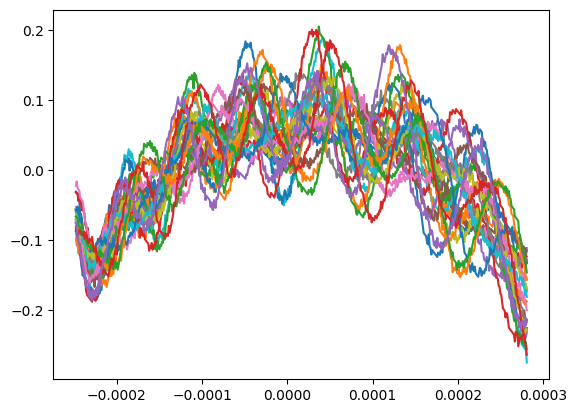

(530, 25)
0.00053


In [ ]:
picture = []
time_chirp = []

# odabrati koje podatke zelimo: odkomentirati jednu od linija
file_paths = [f'podaci1/scope_{i}.csv' for i in range(14, 39)]
#file_paths = [f'podaci2/scope_{i}.csv' for i in range(39, 59)]
#file_paths = [f'DI_PROJEKT/scope_{i}.csv' for i in range(18, 71)]

data = pd.read_csv(file_paths[0])
data_raw = data[1:].copy()
data_raw.columns = ['time', 'VCO', 'I_component']

data_raw['time'] = pd.to_numeric(data_raw['time'], errors='coerce')
data_raw['VCO'] = pd.to_numeric(data_raw['VCO'], errors='coerce')
data_raw['I_component'] = pd.to_numeric(data_raw['I_component'], errors='coerce')
data_raw = data_raw.dropna()

t = data_raw['time'].values
vco = data_raw['VCO'].values
I_signal = data_raw['I_component'].values

dt = t[1] - t[0]
desired_width_in_seconds = 0.00040
width_in_data_points = int(desired_width_in_seconds / dt)

min_indices, _ = find_peaks(-vco, width=width_in_data_points)
max_indices, _ = find_peaks(vco, width=width_in_data_points)

min_indices.sort()
max_indices.sort()

selected_min_idx = None
selected_max_idx = None

for j in range(len(min_indices)):
    m = min_indices[j]
    kandidati_max = max_indices[max_indices > m]
    if len(kandidati_max) > 0:
        selected_min_idx = m
        selected_max_idx = kandidati_max[0]
        T = t[selected_max_idx] - t[selected_min_idx]
        if T >= 0.0005:
            break
        else:
            selected_min_idx = None
            selected_max_idx = None

if selected_min_idx is None or selected_max_idx is None:
    raise ValueError("No valid (min, max) pair found for up-chirp with T >= 0.5ms! Adjust 'distance' or review the data.")


for file_path in file_paths:
    data = pd.read_csv(file_path)
    data_raw = data[1:].copy()
    data_raw.columns = ['time', 'VCO', 'I_component']
    data_raw = data_raw.dropna()
    
    I_signal = pd.to_numeric(data_raw['I_component'], errors='coerce').values
    
    I_segment = I_signal[selected_min_idx:selected_max_idx]
    t_segment = t[selected_min_idx:selected_max_idx]
    
    T = t[selected_max_idx] - t[selected_min_idx]
    time_chirp.append(T)
    
    I_detrended = detrend(I_segment)
    plt.plot(t_segment, I_detrended)
    picture.append(I_detrended)

segment_lengths = [len(seg) for seg in picture]
max_length = np.max(segment_lengths)
for i in range(len(picture)):
    picture[i] = np.pad(picture[i], (0, max_length - len(picture[i])))

picture = np.array(picture)
plt.show()

picture = np.rot90(picture,3)
picture = np.flip(picture)
print(np.shape(picture))
print(T)

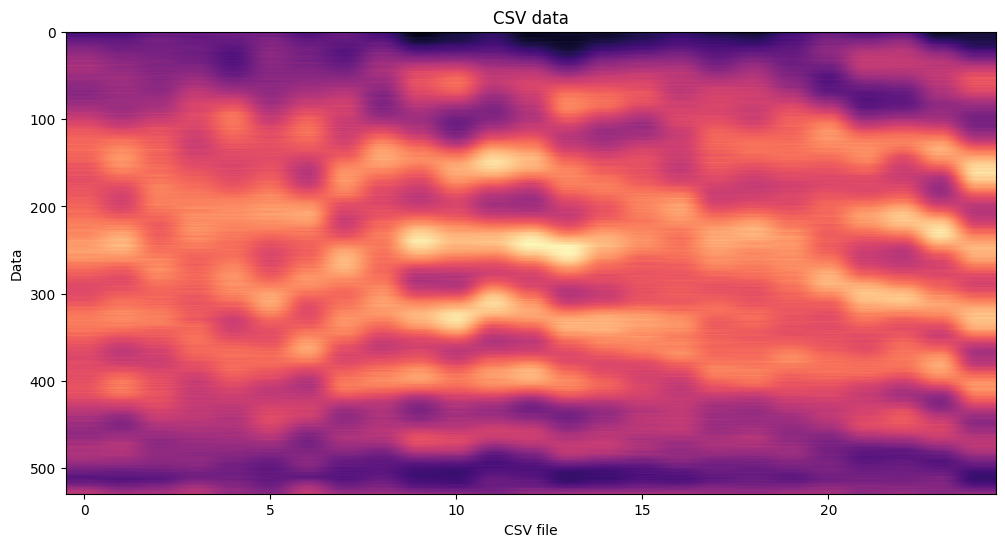

In [191]:
plt.figure(figsize=(12, 6))
plt.imshow(picture, cmap='magma',aspect='auto')
plt.title('CSV data')
plt.xlabel('CSV file')
plt.ylabel('Data')
plt.show()

In [192]:
testnaslika = np.loadtxt("testslika.txt")
testnaslika = detrend(testnaslika)
testnaslika = np.rot90(testnaslika,3)
testnaslika = np.flipud(testnaslika)
print(testnaslika.shape)

(1024, 150)


In [245]:
from scipy.signal import hilbert, windows
from scipy.interpolate import interp1d

def omega_k_algorithm(data, c=3.0e8, fc=24.0e9, bw=1.3e9, T=0.160, step_size=0.005):
    #data = detrend(data)
    sweep = data.shape[0]
    steps = data.shape[1]
    fs = sweep / T  # Uzorkovna frekvencija
    gamma = bw / T  # Nagib chirpa
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    axes[0, 0].imshow(data, cmap='magma', aspect='auto')
    axes[0, 0].set_title("Raw Data")

    # 1. Hilbert transformacija -> kompleksni signal
    data_hilbert = hilbert(data, axis=0)
    axes[0, 1].imshow(np.abs(data_hilbert), cmap='magma', aspect='auto')
    axes[0, 1].set_title("Hilbert Transform")

    # 2. Hanning i Residual video phase/rvp
    f = np.linspace(-fs / 2, fs / 2, sweep)
    rvp = np.exp(-1j * np.pi * f**2 / gamma).reshape(-1,1)
    data_hilbert = data_hilbert * rvp
    
    hanning_win = windows.hann(sweep)
    data_windowed = data_hilbert * hanning_win[:, None]

    axes[0, 2].imshow(np.abs(data_windowed), cmap='magma', aspect='auto')
    axes[0, 2].set_title("Windowing & RVP")

    # 4. Zero-padding /nije napravljeno moze se
    data_padded = data_windowed

    # 5. FFT
    data_cr_fft = np.fft.fft(data_padded, axis=1)
    data_cr_fft = np.fft.fftshift(data_cr_fft, axes=1)

    axes[1, 0].imshow(np.abs(data_cr_fft), cmap='magma', aspect='auto')
    axes[1, 0].set_title("Fourier Domain")

    # 6. Definicija kx i kr
    k_min = (4 * np.pi / c) * (fc - bw / 2)
    k_max = (4 * np.pi / c) * (fc + bw / 2)
    
    kr = np.linspace(k_min, k_max, sweep)
    kx = np.linspace(-np.pi/step_size, np.pi/step_size, steps)


    # 7. Množenje s referentnom funkcijom prije Stolt interpolacije
    Rs = 0.3  # Referentna udaljenost
    phi_mf = -Rs * kr[:, None] + Rs * np.sqrt(np.maximum(kr[:, None]**2 - kx[None, :]**2, 0.0))
    
    S_mf = data_cr_fft*np.exp(1j * phi_mf)
    
    # 8. Stolt interpolacija (kr -> ky)
    S_st = []
    KY = kr
    
    for idx in range(len(kx)):
        ky = np.sqrt(np.maximum(kr**2 - kx[idx]**2, 0.0))
        f_interp = interp1d(ky, S_mf[:, idx], kind='linear', fill_value="extrapolate")
        S_st.append(f_interp(KY))

    S_st = np.array(S_st)
    hann = windows.hann(sweep)
    S_st = S_st * hann
    #S_st = np.pad(S_st, ((256,256), (0,0)), mode='constant')
    axes[1, 1].imshow(np.abs(S_st), cmap='magma', aspect='auto')
    axes[1, 1].set_title("Stolt Transform")

    # 9. Inverzna FFT duž po obje osi
    final_image = S_st
    
    final_image = np.fft.ifft(final_image, axis=1)
    final_image = np.fft.ifftshift(final_image, axes=1)
    final_image = np.fft.ifftshift(final_image, axes=0)
    final_image = np.fft.ifft(final_image, axis=0)
    
    # 10. Uređivanje za točan oblik
    final_image = np.asmatrix(final_image)
    final_image = np.rot90(final_image)
    final_image = np.flip(final_image)
    final_image = np.flip(final_image,axis=1)
    
    # 11. Prikaz SAR slike
    axes[1, 2].imshow(np.abs(final_image), cmap='magma', aspect='auto')
    axes[1, 2].set_title("SAR Image")

    plt.tight_layout()
    plt.show()
    return final_image

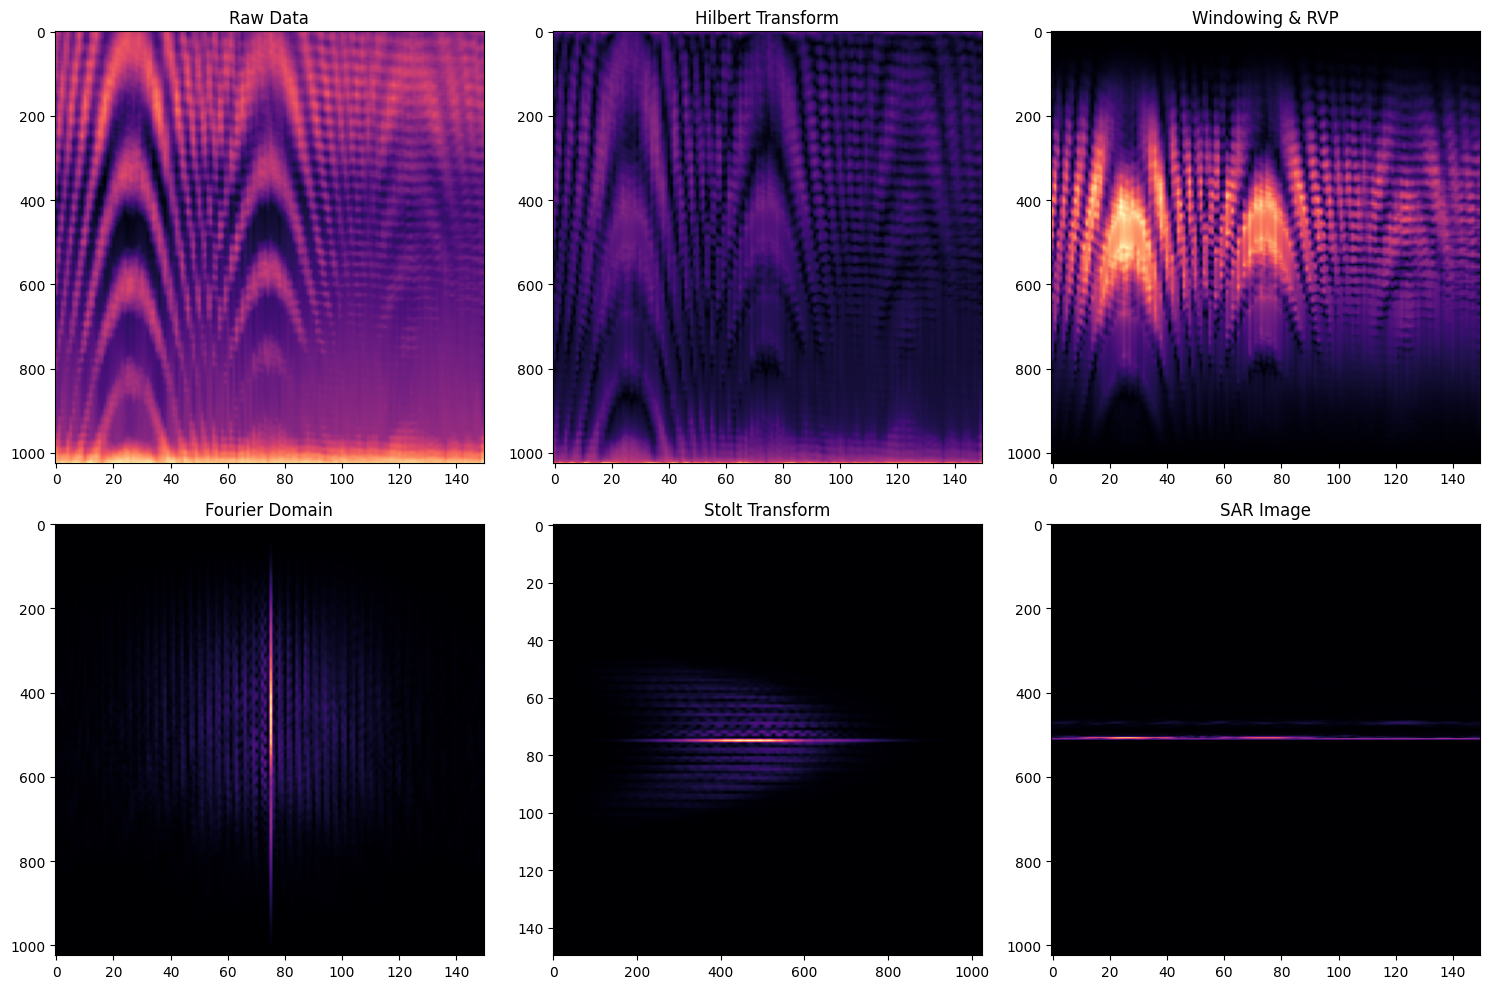

In [246]:
pic = omega_k_algorithm(testnaslika)

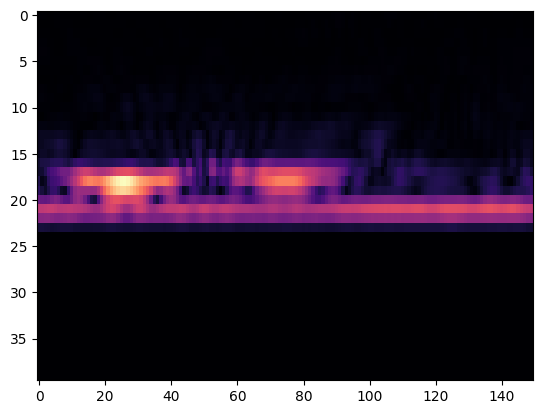

In [247]:
slika = pic[490:530,:]
plt.figure()
plt.imshow(np.abs(slika), cmap='magma', aspect='auto')
plt.show()

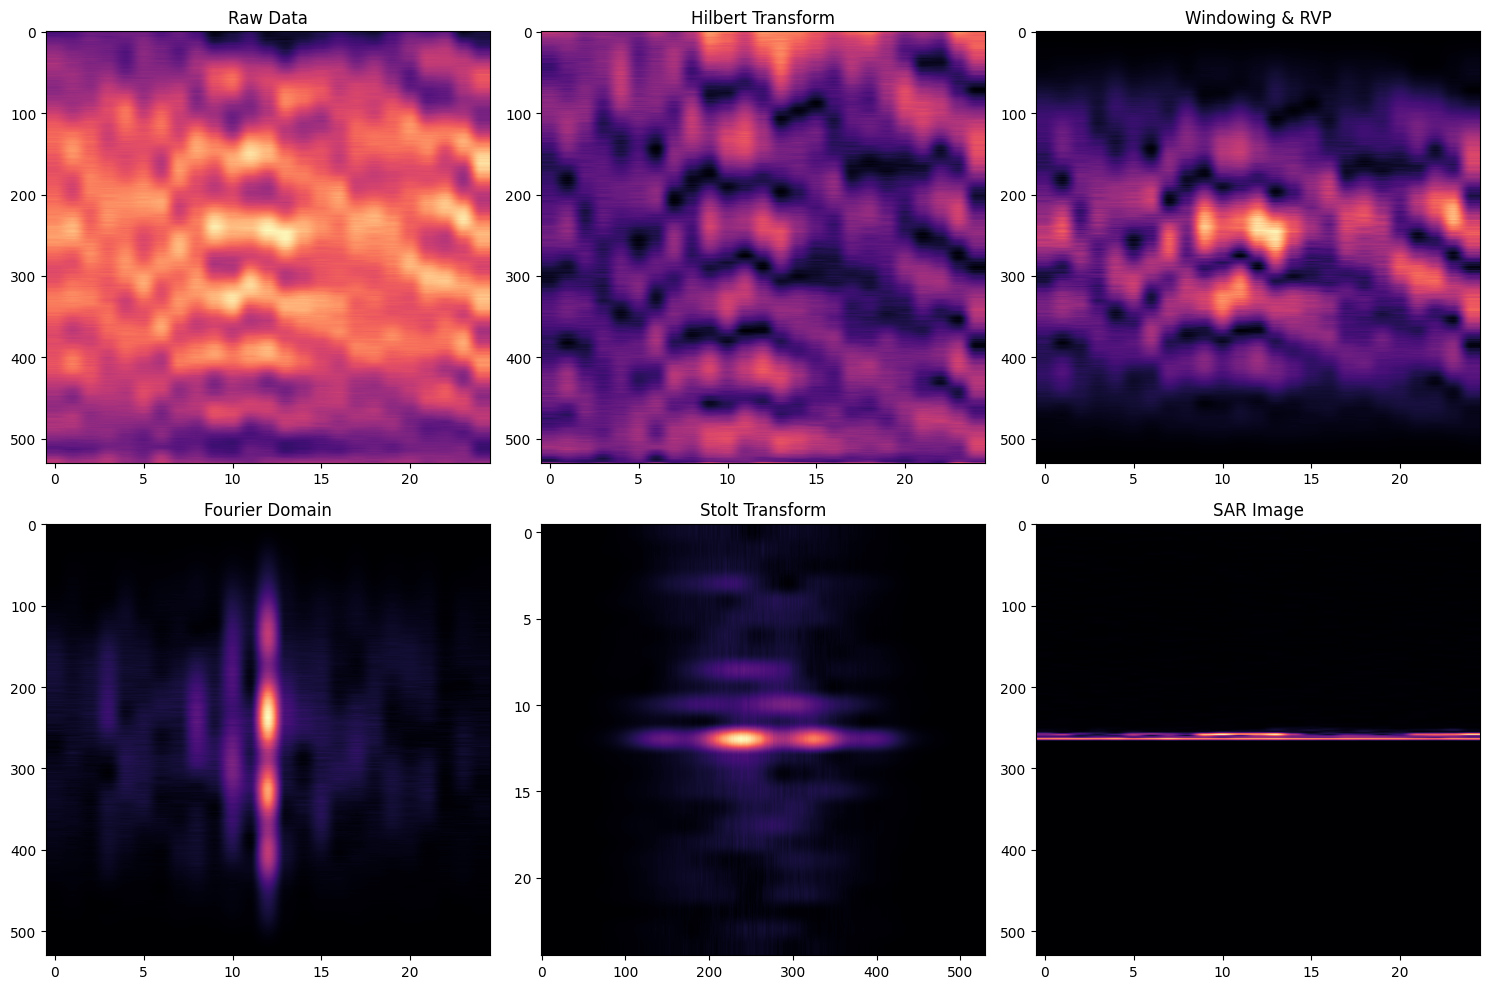

In [248]:
pict = omega_k_algorithm(picture, bw = 1.24e9, T = T, step_size=0.05)

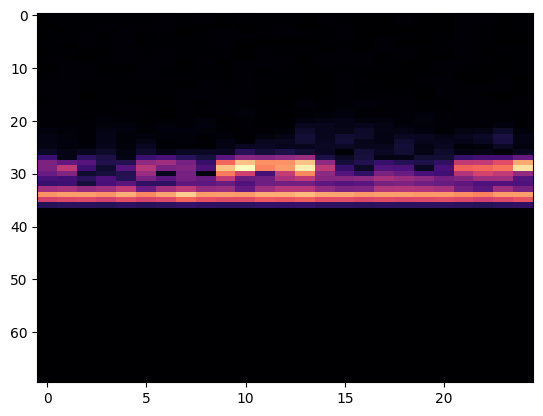

In [ ]:
mjerenja = pict[230:300,:]
plt.figure()
plt.imshow(np.abs(mjerenja), cmap='magma', aspect='auto')
plt.show()